# Titanic : Machine learning from Disaster
Author - Rishabh Jain

In [1]:
import warnings,os,math
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Loading Train and Test set

In [2]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
recordId='PassengerId'
target='Survived'
trainId=train[recordId]
testId=test[recordId]

# Dropping **PassengerId** (unique identifier) feature from train & test set.
train.drop(recordId,axis=1,inplace=True)
test.drop(recordId,axis=1,inplace=True)

# Checking Dataset shape
print('Train Set\t %d X %d'%(train.shape[0],train.shape[1]))
print('Test Set\t %d X %d'%(test.shape[0],test.shape[1]))

Train Set	 891 X 11
Test Set	 418 X 10


## Data Preprocessing

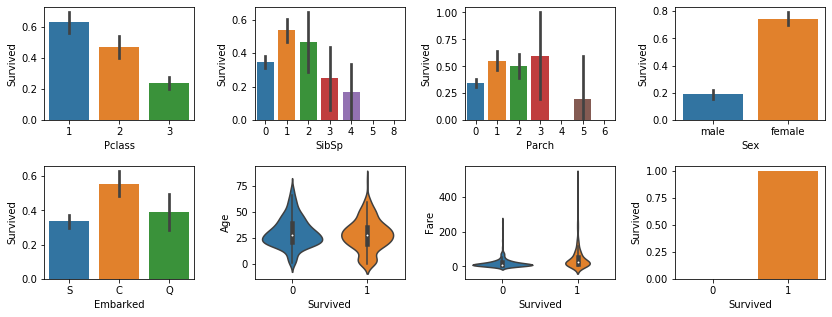

In [4]:
features=['Pclass','SibSp','Parch','Sex','Embarked','Age','Fare','Survived']
nrows=2
ncols=int(np.ceil(len(features)/nrows))
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(14,5))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
for row in range(nrows):
    for col in range(ncols):
        feature=features[row*ncols+col]
        if feature in ['Age','Fare']:
            sns.violinplot(train[target],train[feature],ax=ax[row,col])
        else:
            sns.barplot(train[feature],train[target],ax=ax[row,col])            

**Few observations from the plots :**
- **Pclass -** An ordinal feature where passsenger with `Pclass=1` had higher probablitly of surviving than compared to passenger with `Pclass=3`.
- **SibSp -** Passengers with lesser number of siblings and spouses had higher chances of surviving.
- **Sex -** Females were more likely to survive in titanic disaster.
- **Embarked -** Passengers who embarked at port C had higher probability than other passengers.
- **Fare -** Passengers who paid higher fare or in other words passengers with higher socio-economic status had better better chance of survival.

**Let's first concatenate the train and test set for handling missing data and feature engineering**

In [5]:
nTrain=train.shape[0]
nTest=test.shape[0]
trainY=train[target]
allData=pd.concat((train,test)).reset_index(drop=True)
allData.drop(target,axis=1,inplace=True)
print('Train + Test Set\t %d X %d'%(allData.shape[0],allData.shape[1]))

Train + Test Set	 1309 X 10


### Handling Missing Data

In [6]:
count=allData.isnull().sum().sort_values(ascending=False)
percentage=(allData.isnull().sum()/allData.isnull().count()).sort_values(ascending=False)*100
dtypes=allData[count.index].dtypes
missingData=pd.DataFrame({'Count':count,'Percentage':percentage,'Type':dtypes})
missingData.drop(missingData[missingData['Count']==0].index,inplace=True)
missingData.head(10)

,Count,Percentage,Type
Cabin,1014,77.463713,object
Age,263,20.091673,float64
Embarked,2,0.152788,object
Fare,1,0.076394,float64


Since, **Cabin** feature is directly propotional to Socio-economic status of the passenger and contains the deck information. We will keep this feature by replacing the passengers with `Cabin=NaN` value replaced by `M`.

In [7]:
idx=allData[allData['Cabin'].isnull()].index
allData.loc[idx,'Cabin']='M'

According to the plots above, **Survival** of the passenger is not affected much by the age. We are going to drop this feature.

In [8]:
allData.drop(columns=['Age'],inplace=True)

After, looking at the names of the passenger with their embarkement port missing on internet, we can conclude that :
- Icard, Miss. Amelie embarked for Southampton ([source](https://www.encyclopedia-titanica.org/titanic-survivor/)).
- Martha Evelyn emabarked for Southampton ([source](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)).

In [9]:
allData[allData['Embarked'].isnull()]

,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,"Icard, Miss. Amelie",female,0,0,113572,80.0,B28,NaN
829,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,0,0,113572,80.0,B28,NaN


In [10]:
idx=allData[allData['Embarked'].isnull()].index
allData.loc[idx,'Embarked']='S'

Only one passenger is there with fare missing. We will deal with this by following these steps :
- First identify if this passenger is from train or test set using passenger name.
- Replace the fare value with the mean fare of passengers with `Pclass=3`,`Sex=male` and `Embarked=S` in train/test set.

In [11]:
allData[allData['Fare'].isnull()]

,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,3,"Storey, Mr. Thomas",male,0,0,3701,NaN,M,S


In [12]:
name=allData[allData['Fare'].isnull()].Name.values[0]
dataset=train if name in train['Name'].tolist() else test
groups=dataset.groupby(['Pclass','Sex','Embarked'])['Fare'].mean().to_frame('Mean Fare')
groups

Mean Fare
Pclass Sex    Embarked            
1      female C         123.895682
              Q          90.000000
              S         105.737110
       male   C          96.251339
              S          55.634341
2      female C          30.040625
              S          25.884615
       male   C          14.451771
              Q          11.273950
              S          21.641827
3      female C          11.360950
              Q           9.051813
              S          16.825610
       male   C          10.450626
              Q           8.931483
              S          12.718872

In [13]:
idx=allData[allData['Fare'].isnull()].index
allData.loc[idx,'Fare']=groups.loc[3,'male','S'].values[0]

Verifying if the all the missing values are dealt with.

In [14]:
count=allData.isnull().sum().sort_values(ascending=False).to_frame(name='count')
count

,count
Embarked,0
Cabin,0
Fare,0
Ticket,0
Parch,0
SibSp,0
Sex,0
Name,0
Pclass,0


### Feature Engineering
Here, we are going to create few new features :

- **FamilySize -** Created by adding **SibSp** and **Parch** variables with 1.
- **IsAlone -** Binary feature will be created by setting its value to 1 if **FamilySize** is 1 otherwise 0 value will be set.
- **Title -** Extracted by the **Name** feature. Moreover, all the Titles whose occurrences is less than 10 are replaced with **'Misc'**.
- **Deck -** Extracted by the **Cabin** feature.

After the new features are derived, **Name**,**Cabin** and **Ticket** features will be dropped from the dataframe.

In [15]:
# FamilySize
allData['FamilySize']=allData['SibSp']+allData['Parch']+1
# IsAlone
allData['IsAlone']=None
idx=allData[allData['FamilySize']==1].index
allData.loc[idx,'IsAlone']=1
idx=allData[allData['FamilySize']>1].index
allData.loc[idx,'IsAlone']=0
allData['IsAlone']=allData['IsAlone'].astype(int)
# Title
allData['Title']=allData['Name'].str.extract(" ([A-Za-z]+)\.")
titleNames=(allData['Title'].value_counts()<10)
allData['Title']=allData['Title'].apply(lambda title: 'Misc' if titleNames.loc[title]==True else title)
# Deck
allData['Deck']=allData['Cabin'].str[0]
# Dropping Name, Cabin and Ticket feature
allData.drop(columns=['Name','Cabin','Ticket'],inplace=True)

In [16]:
allData.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,Deck
0,3,male,1,0,7.2500,S,2,0,Mr,M
1,1,female,1,0,71.2833,C,2,0,Mrs,C
2,3,female,0,0,7.9250,S,1,1,Miss,M
3,1,female,1,0,53.1000,S,2,0,Mrs,C
4,3,male,0,0,8.0500,S,1,1,Mr,M


**Let's take a look at how our new features effect the survival of a passenger in training set.**

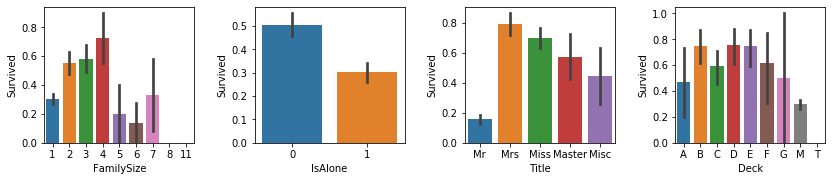

In [17]:
_train=allData[:nTrain]
features=['FamilySize','IsAlone','Title','Deck']
nrows=1
ncols=int(np.ceil(len(features)/nrows))
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(14,2.5))
fig.subplots_adjust(wspace=0.4,hspace=0.4)
for col in range(ncols):
    feature=features[col]
    if feature is not 'Deck':
        sns.barplot(_train[feature],trainY,ax=ax[col])
    else:
        sns.barplot(_train[feature],trainY,ax=ax[col],order=['A','B','C','D','E','F','G','M','T'])

**It's important to understand if the Cabin/Deck are assigned to passengers based on socio-economic status.**<br><br>
<img src="images/Titanic_side_plan.png" style="width:700px;">

In [18]:
_train.groupby(['Deck','Pclass']).size().to_frame(name='Passenger Count')

Passenger Count
Deck Pclass                 
A    1                    15
B    1                    47
C    1                    59
D    1                    29
     2                     4
E    1                    25
     2                     4
     3                     3
F    2                     8
     3                     5
G    3                     4
M    1                    40
     2                   168
     3                   479
T    1                     1

From the table above, we can clearly conclude few things :
- Deck A,B,C and T were only reserved for passenger with `Pclass=1` and will be replaced by 'ABC'.
- Deck D & E were reserved for passengers with `Pclass=1,2,3` and will be replaced by 'DE'.
- Deck F & G were reserved for passengers with `Pclass=2,3` and will be replace by 'FG'.
- Deck M is just a placeholder values for passengers with no cabins.

This way, we will have reduced the cardinality of deck feature from 9 to 4.

In [19]:
allData['Deck']=allData['Deck'].replace(['A','B','C','T'],'ABC')
allData['Deck']=allData['Deck'].replace(['D','E'],'DE')
allData['Deck']=allData['Deck'].replace(['F','G'],'FG')
allData['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

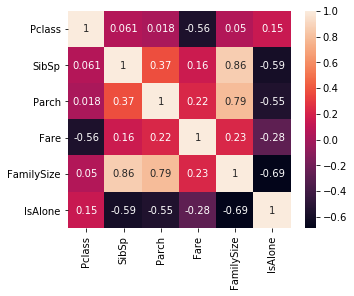

In [20]:
fig,ax=plt.subplots(figsize=(5,4))
corrMat=allData.corr()
sns.heatmap(corrMat,annot=True)

**Converting Categorical variables into Dummy variables**

In [21]:
allData=pd.get_dummies(allData)
print('Train + Test Set\t %d X %d'%(allData.shape[0],allData.shape[1]))
allData.sample(5)

Train + Test Set	 1309 X 20


,Pclass,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Deck_ABC,Deck_DE,Deck_FG,Deck_M
129,3,0,0,6.9750,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1
1163,1,1,0,136.7792,2,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
386,3,5,2,46.9000,8,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1
829,1,0,0,80.0000,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0
159,3,8,2,69.5500,11,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1


**Splitting dataset back to training and test set**

In [22]:
trainX=allData[:nTrain]
testX=allData[nTrain:]

## Modeling
Train Validation Split on Training Data (for Cross Validation)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Splitting training set further into training and validation set
subTrainX,valX,subTrainY,valY=train_test_split(trainX,trainY,test_size=0.2,random_state=42)

Here, we will try several models:
- Nearest Neighbors
- Linear SVM
- RBF SVM
- Decision Tree
- Random Forest 
- Neural Net
- Logistic Regression

In [24]:
classifiers={
    "Nearest Neighbors":KNeighborsClassifier(3), 
    "Linear SVM":SVC(kernel='linear'), 
    "RBF SVM":SVC(kernel='rbf'),
    "Decision Tree":DecisionTreeClassifier(max_features=10,max_depth=10), 
    "Random Forest":RandomForestClassifier(n_estimators=200,max_features=10,max_depth=10), 
    "Neural Net":MLPClassifier(alpha=0.001),
    "Logistic Regression":LogisticRegression()
}

,classifier,train,test
4,Random Forest,0.925562,0.837989
3,Decision Tree,0.904494,0.826816
5,Neural Net,0.858146,0.826816
1,Linear SVM,0.832865,0.815642
6,Logistic Regression,0.831461,0.810056
0,Nearest Neighbors,0.866573,0.804469
2,RBF SVM,0.685393,0.659218


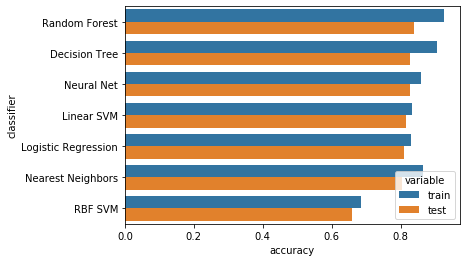

In [25]:
# Training
models_accuracy=[]
i=0
for classifier_name,classifier in classifiers.items():
    i+=1
    print("Training classifiers{}".format("."*i),end='\r')
    classifier.fit(subTrainX,subTrainY)
    predictions=classifier.predict(subTrainX)
    train_accuracy=accuracy_score(subTrainY,predictions)
    predictions=classifier.predict(valX)
    test_accuracy=accuracy_score(valY,predictions)
    models_accuracy.append({
        'classifier':classifier_name,
        'train':train_accuracy,
        'test':test_accuracy
    })
models_accuracy=pd.DataFrame(models_accuracy)
models_accuracy=models_accuracy.sort_values(by=['test','train'],ascending=False)
df=models_accuracy.melt(
    id_vars='classifier',
    value_name='accuracy'
)
sns.barplot(x='accuracy',y='classifier',hue='variable',data=df);
models_accuracy

Let's take a look at the TOP 10 important features for Random Forest classifier.

In [26]:
feature_importance=pd.DataFrame({'feature':subTrainX.columns,'importance':classifiers['Random Forest'].feature_importances_})
feature_importance=feature_importance.sort_values(by='importance',ascending=False)
feature_importance.head(10)

,feature,importance
3,Fare,0.240759
7,Sex_male,0.140653
14,Title_Mr,0.137252
6,Sex_female,0.110197
0,Pclass,0.091946
4,FamilySize,0.068896
1,SibSp,0.039837
19,Deck_M,0.026775
2,Parch,0.020766
11,Title_Master,0.020537


### For Final Submission
**We can conclude that amongst all the classifiers, RANDOM FOREST has the highest test accuracy. Lets train the Random Forest classifier with the ENTIRE TRAINING DATA for better predictions on final test set.**
#### Training

In [27]:
rfc=RandomForestClassifier(n_estimators=200,max_features=10,max_depth=10)
rfc.fit(trainX,trainY)
predictions=rfc.predict(trainX)
accuracy=accuracy_score(trainY,predictions)
print('TRAINING ACCURACY : {:.4f}'.format(accuracy))

TRAINING ACCURACY : 0.9270


#### Final Prediction

In [28]:
predictions=rfc.predict(testX)
submission=pd.DataFrame()
submission[recordId]=testId
submission[target]=predictions
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [29]:
submission.to_csv('results/submission.csv',index=False)